# Домашнее задание №3

<span style="color: red; font-size: 14pt">Дедлайн: 20 марта 23:59</span>

Машинное обучение, ФИВТ, Весна 2018

**Оформление дз**: 
- Присылайте выполненное задание на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2018_fall <номер_группы> <фамилия>``, к примеру -- ``ML2018_fall 596 ivanov``
- Выполненное дз сохраните в файл ``ML2018_<фамилия>_<группа>_task<номер задания>.ipnb``, к примеру -- ``ML2018_ivanov_596_task1.ipnb``

**Вопросы**:
- Присылайте вопросы на почту ``ml.course.mipt@gmail.com`` (или в телеграм-канал)
- Укажите тему письма в следующем формате ``ML2018_fall Question <Содержание вопроса>``

--------
- **PS1**: Используются автоматические фильтры, мы не найдем ваше дз, если вы укажете тему письма в неправильном формате.
- **PS2**: Просроченный дедлайн снижает максимальный вес задания по формуле, указнной на первом семинаре

## Часть 1. Теоретические задачи

##### 30% баллов за задание, оценочное время выполнения 30 минут

### Задача 1 (10% баллов)

Предположим, что мы решаем задачу бинарной классификации и что у нас есть три алгоритма $b_1(x)$, $b_2(x)$ и $b_3(x)$, каждый из которых ошибается с вероятностью p. Мы строим композицию взвешенным голосованием: алгоритмам присвоены значимости $w_1$, $w_2$ и $w_3$, и для вынесения вердикта суммируются значимости алгоритмов, проголосовавших за каждый из классов:

$$a_0 = \sum_{i=1}^3 w_i [b_i(x)=0]$$
$$a_1 = \sum_{i=1}^3 w_i [b_i(x)=1]$$


Объект $x$ относится к классу, для которого такая сумма оказалась максимальной. Например, если первые два алгоритма голосуют за класс $0$, а третий — за класс $1$, то выбирается класс $0$, если $w_1 + w_2 > w_3$, и класс $1$ в противном случае. Какова вероятность ошибки такой композиции этих трех алгоритмов, если:
1. $w_1 = 0.2, w_2 = 0.3, w_3 = 0.2$;
2. $w_1 = 0.2, w_2 = 0.5, w_3 = 0.2$? 

![Image](IMG_6633.JPG)

### Задача 2 (10% баллов)

Рассмотрим задачу бинарной классификации. Будем считать, что все алгоритмы из базового семейства возвращают ответы из отрезка $[0,1]$, которые можно интерпретировать как вероятности принадлежности объектов классу $1$. В качестве функции потерь возьмем отрицательный логарифм правдоподобия:
$$L(y,z) = -(y \log{z}+(1-y)\log{(1-z)})$$
В формуле $y$ - правильный ответ, $z$ - ответ алгоритма. Выпишите формулы для поиска базовых алгоритмов $b_n$ и коэффициентов $\gamma_n$ в градиентном бустинге.

In [ ]:
# Ваш ответ здесь

### Задача 3 (10% баллов)

Известно, что на $n$-й итерации двухклассового метода AdaBoost
был выбран базовый классификатор, допускающий ошибку только на одном объекте $x_j$. Найдите нормированный вес $w_j^{(n+1)}$ при этом объекте на следующей итерации.

![Image](IMG_1282.JPG)

## Часть 2. Random Forest

##### 70% баллов за задание, оценочное время выполнения 3 часа

### Реализация (40%)

**Необходимо реализовать класс `RandomForest`** (для решения задачи классификации)

**Спецификация:**
- класс наследуется от `sklearn.BaseEstimator`;
- конструктор содержит следующие параметры: 
    - `num_trees` - количество деревьев в лесе;
    - `max_depth` - максимальная глубина дерева (по умолчанию - `numpy.inf`); 
    - `max_features` - количество признаков, принимаемое к рассмотрению при разбиении (аналогичный параметр есть в sklearn имплементации). Параметр может принимать значения:
        - int - тогда рассматриваем max_features признаков при каждом разбиении;
        - float - max_features обозначает процент, int(max_features * n_features) признаков рассматривается при каждом разбиении;
        - “sqrt” - max_features=sqrt(n_features);
        - “log2” - max_features=log2(n_features);
        - None - max_features=n_features;
    - `criterion` - критерий разбиения (для классификации - 'gini' или 'entropy', по умолчанию - 'gini'); функции с подсчетом энтропийного и критерия Джини можно взять из предыдущего дз;
    
- класс имеет методы `fit` и `predict`;
- метод `fit` принимает матрицу объектов `X` и вектор ответов `y` (объекты `numpy.ndarray`) и возвращает экземпляр класса
    `RandomForest`, представляющий собой Random Forest, обученный по выборке `(X, y)` с учётом заданных в конструкторе параметров; 
- метод `predict` принимает матрицу объектов и возвращает вектор предсказанных ответов;

In [145]:
import numpy as np
import sklearn
from sklearn.tree import DecisionTreeClassifier
from joblib import Parallel, delayed
import multiprocessing
from multiprocessing.dummy import Pool as ThreadPool
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import scipy.stats as sps
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

In [226]:
def bagging(X, y, size):
    mask_sample = np.random.choice(np.arange(0, len(y), dtype=np.int), size=size)
    sample_X, sample_y = X[mask_sample], y[mask_sample]
    return sample_X, sample_y

In [227]:
class RandomForest(sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin):
    def __init__(self, num_trees, max_features=None, max_depth=np.inf, criterion='gini', n_jobs=-1):
        self.num_trees = num_trees
        self.max_depth = max_depth if max_depth < np.inf else None
        self.max_features = max_features
        self.criterion = criterion
        self.n_jobs = n_jobs if n_jobs > 0 else multiprocessing.cpu_count()
        self.trees = []

    def fit(self, X_train, y_train):
        '''
        Create trees here, using bagging and RSM.
        '''
        self.max_features = self._get_max_features(X_train.shape[1])
        # no_multiprocessing:
        # self.trees = [self._fit_tree(i) for i in range(self.num_trees)]

        # multiprocessing:
        with multiprocessing.Pool(self.n_jobs) as pool:
            self.trees = pool.map(self._fit_tree, range(self.num_trees))

        return self

    def predict(self, X_test):
        '''
        Predict the label here using your grown trees.
        '''
        self._X_test = X_test

        # no_multiprocessing:
        # y_pred = np.array([self._predict_tree(clf) for clf in self.trees])

        # multiprocessing:
        with multiprocessing.Pool(self.n_jobs) as pool:
            y_pred = np.array(pool.map(self._predict_tree, self.trees))

        y_pred = sps.mode(y_pred, axis=0)[0].ravel()
        return y_pred
    
    def _get_max_features(self, n_features):
        if self.max_features == 'sqrt':
            return int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            return int(np.log2(n_features))
        elif self.max_features is None:
            return n_features
        elif isinstance(self.max_features, int):
            assert 1 <= self.max_features <= n_features
            return self.max_features
        elif isinstance(self.max_features, float):
            assert 0 < self.max_features <= 1
            return int(self.max_features * n_features)
        else:
            raise ValueError

    def _fit_tree(self, _):
        X_sample_i, y_sample_i = bagging(X, y, len(y))
        clf = DecisionTreeClassifier(
            criterion=self.criterion,
            max_depth=self.max_depth,
            max_features=self.max_features
        )
        clf.fit(X_sample_i, y_sample_i)
        return clf

    def _predict_tree(self, clf):
        return clf.predict(self._X_test)

### Тестирование (15%)

Загрузите датасет Wine Data Set (https://archive.ics.uci.edu/ml/datasets/wine). Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=42`. Попробуйте обучить Random Forest на предложенном датасете

In [36]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data

--2018-03-19 22:25:05--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data
Resolving archive.ics.uci.edu... 128.195.10.249
Connecting to archive.ics.uci.edu|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10782 (11K) [text/plain]
Saving to: ‘wine.data’

wine.data           100%[===================>]  10.53K  --.-KB/s    in 0.001s  

2018-03-19 22:25:06 (8.96 MB/s) - ‘wine.data’ saved [10782/10782]



In [228]:
cols = [
    'Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 
    'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue',
    'OD280/OD315 of diluted wines', 'Proline'
]
wine_data = pd.read_csv('wine.data', delimiter=',', header=None, names=cols)
wine_data[:2]
X, y = wine_data.drop(['Class'], axis=1).values, wine_data['Class'].values

In [229]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [230]:
rf = RandomForest(num_trees=100, max_depth=11, criterion='gini')

In [231]:
rf.fit(X_train, y_train)

RandomForest(criterion='gini', max_depth=11, max_features=13, n_jobs=8,
       num_trees=100)

In [232]:
accuracy_score(y_test, rf.predict(X_test))

1.0

In [219]:
rf_sklearn = RandomForestClassifier(n_estimators=100)
rf_sklearn.fit(X_train, y_train)
accuracy_score(y_test, rf_sklearn.predict(X_test))

1.0

Покажите, как менялись значения критерия качества `accuracy` при увеличении параметра num_trees. Видны ли следы переобучения?

In [150]:
nums_trees = np.arange(1, 150, dtype=np.int)
train_acc = []
test_acc = []
for num_tree in tqdm(nums_trees):
    rf = RandomForest(num_trees=num_tree, max_depth=5, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, rf.predict(X_train)))
    test_acc.append(accuracy_score(y_test, rf.predict(X_test)))

100%|██████████| 149/149 [01:19<00:00,  1.87it/s]


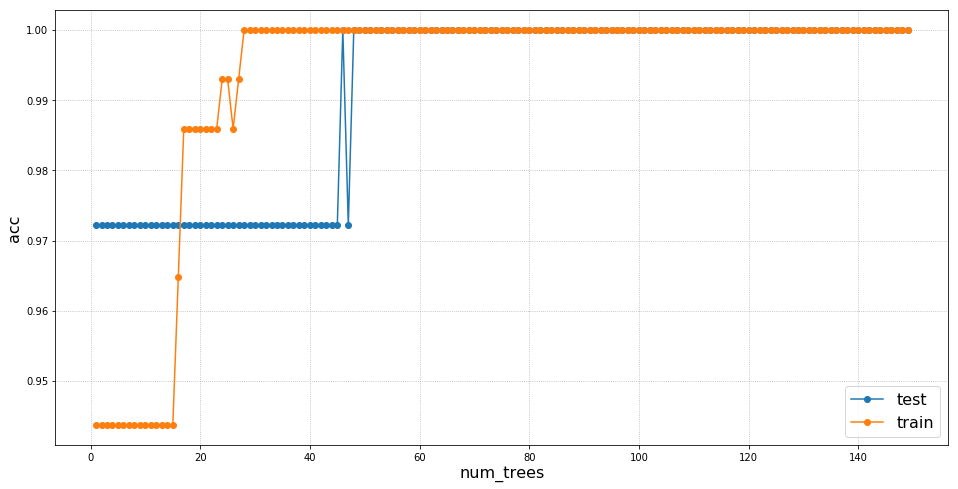

In [165]:
plt.figure(figsize=(16, 8))
plt.plot(nums_trees, test_acc, '-o', label='test')
plt.plot(nums_trees, train_acc,'-o', label='train')
plt.grid(ls=':')
plt.ylabel('acc', fontsize=16)
plt.xlabel('num_trees', fontsize=16)
plt.legend(fontsize=16, loc=4)
plt.show()

Я бы не сказал, что видны следы переобучения. Наверное, тестовая выборка слишком маленькая, чтобы сделать такое заключение.

Скажу, что алгоритм сразу же выдает отличное качество и на обучающем, и на тестовом сете
(качество на 40-60ой эпохах > 0.97, а на трейне 1. Казалось бы, переобучение, судя по трейну, но нет, тестовое качество отличное везде)

Сравните качество работы вашей реализации RandomForest и реализации из sklearn.

In [166]:
nums_trees = np.arange(1, 150, dtype=np.int)
my_rf_acc = []
sklearn_rf_acc = []
for num_tree in tqdm(nums_trees):
    rf = RandomForest(num_trees=num_tree, max_depth=5, n_jobs=-1)
    rf_sklearn = RandomForestClassifier(n_estimators=num_tree, max_depth=5, n_jobs=-1)
    rf.fit(X_train, y_train)
    rf_sklearn.fit(X_train, y_train)
    my_rf_acc.append(accuracy_score(y_test, rf.predict(X_test)))
    sklearn_rf_acc.append(accuracy_score(y_test, rf_sklearn.predict(X_test)))

100%|██████████| 149/149 [01:32<00:00,  1.61it/s]


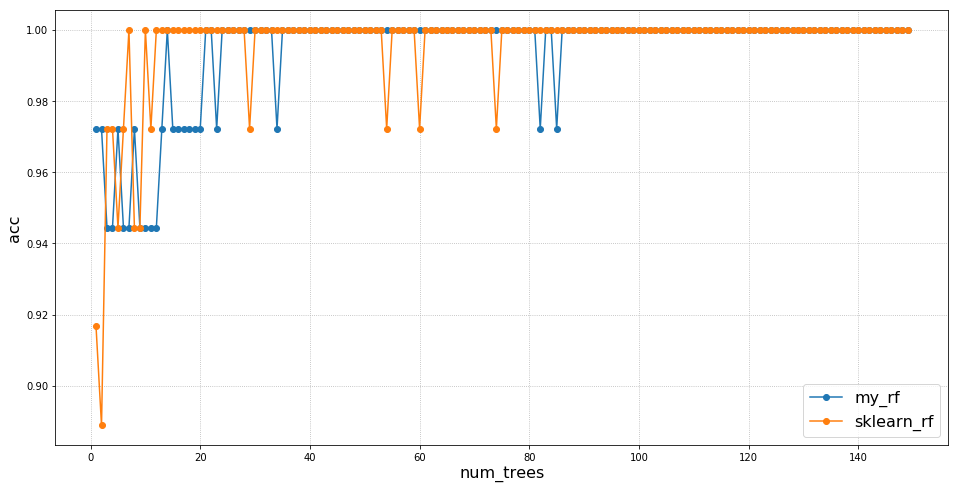

In [167]:
plt.figure(figsize=(16, 8))
plt.plot(nums_trees, my_rf_acc, '-o', label='my_rf')
plt.plot(nums_trees, sklearn_rf_acc,'-o', label='sklearn_rf')
plt.grid(ls=':')
plt.ylabel('acc', fontsize=16)
plt.xlabel('num_trees', fontsize=16)
plt.legend(fontsize=16, loc=4)
plt.show()

Видим, что точность моего алгоритма и алгоритма из skleran на данном датасете примерно одинаковая. Просадки вниз скорее всего из-за четности степени голосующих и рандома

### Модификация Random Forest (15%)

Измените свою реализацию `RandomForest` так, чтобы случайное подмножество признаков выбиралось не в каждом сплите, а перед построением всего дерева. Сравните результат работы с обычным RandomForest.

In [233]:
class RandomForest_v2(sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin):
    def __init__(self, num_trees, max_features=None, max_depth=np.inf, criterion='gini', n_jobs=-1):
        self.num_trees = num_trees
        self.max_depth = max_depth if max_depth < np.inf else None
        self.max_features = max_features
        self.criterion = criterion
        self.n_jobs = n_jobs if n_jobs > 0 else multiprocessing.cpu_count()
        self.trees = []
        self.features = {}

    def fit(self, X_train, y_train):
        '''
        Create trees here, using bagging and RSM.
        '''
        self.max_features = self._get_max_features(X_train.shape[1])
        # no_multiprocessing:
        # trees_and_features = [self._fit_tree(i) for i in range(self.num_trees)]

        # multiprocessing:
        with multiprocessing.Pool(self.n_jobs) as pool:
            trees_and_features = np.array(pool.map(self._fit_tree, range(self.num_trees)))
        
        self.trees, self.features = trees_and_features[:, 0], trees_and_features[:, 1]
        return self

    def predict(self, X_test):
        '''
        Predict the label here using your grown trees.
        '''
        self._X_test = X_test

        # no_multiprocessing:
        # y_pred = np.array([self._predict_tree(i) for i in range(len(self.trees))])

        # multiprocessing:
        with multiprocessing.Pool(self.n_jobs) as pool:
            y_pred = np.array(pool.map(self._predict_tree, range(len(self.trees))))

        y_pred = sps.mode(y_pred, axis=0)[0].ravel()
        return y_pred
    
    def _get_max_features(self, n_features):
        if self.max_features == 'sqrt':
            return int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            return int(np.log2(n_features))
        elif self.max_features is None:
            return n_features
        elif isinstance(self.max_features, int):
            assert 1 <= self.max_features <= n_features
            return self.max_features
        elif isinstance(self.max_features, float):
            assert 0 < self.max_features <= 1
            return int(self.max_features * n_features)
        else:
            raise ValueError

    def _fit_tree(self, i):
        X_sample_i, y_sample_i = bagging(X, y, len(y))
        feaures_i = np.random.choice(np.arange(0, X_sample_i.shape[1], dtype=np.int), 
                                   size=self.max_features, replace=False)
        clf = DecisionTreeClassifier(
            criterion=self.criterion,
            max_depth=self.max_depth
        )
        clf.fit(X_sample_i[:, feaures_i], y_sample_i)
        return [clf, feaures_i]

    def _predict_tree(self, i):
        features_i = self.features[i]
        clf = self.trees[i]
        return clf.predict(self._X_test[:, features_i])

In [234]:
nums_trees = np.arange(1, 150, dtype=np.int)
rf_acc = []
rf_v2_acc = []
for num_tree in tqdm(nums_trees):
    rf = RandomForest(num_trees=num_tree, max_depth=5, n_jobs=-1)
    rf_v2 = RandomForest_v2(num_trees=num_tree, max_depth=5, n_jobs=-1)
    rf.fit(X_train, y_train)
    rf_v2.fit(X_train, y_train)
    rf_acc.append(accuracy_score(y_test, rf.predict(X_test)))
    rf_v2_acc.append(accuracy_score(y_test, rf_v2.predict(X_test)))

100%|██████████| 149/149 [01:44<00:00,  1.42it/s]


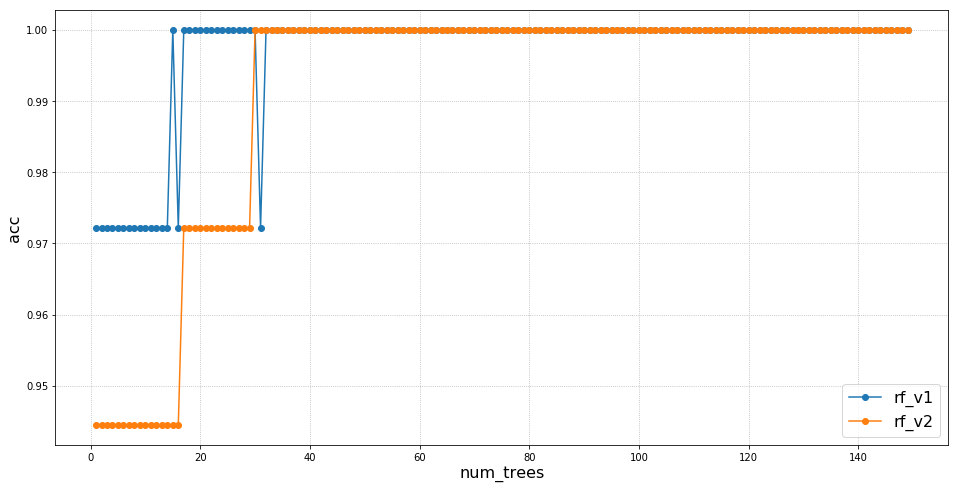

In [237]:
plt.figure(figsize=(16, 8))
plt.plot(nums_trees, rf_acc, '-o', label='rf_v1')
plt.plot(nums_trees, rf_v2_acc,'-o', label='rf_v2')
plt.grid(ls=':')
plt.ylabel('acc', fontsize=16)
plt.xlabel('num_trees', fontsize=16)
plt.legend(fontsize=16, loc=4)
plt.show()

Видим, что модификация RF выходит на плато на бОльшем количестве деревьев. При увеличении количества деревьев они все-таки сравниваются. Я бы все-таки предпочел первый вариант построения в силу сходимости на меньшем количестве деревьев. 